In [1]:
import sys
import os

sys.path.append("Two_layers")
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "/Two_layers/data"

HPO_name = "greedy_HPO"
method_name = "GroHess_two_layers"
benchmark_name = "pMNIST"

In [2]:
from lib.abstract_torch import get_device
from lib.dataloader import get_task_loaders
from lib.models import ANN
from lib.train import train
from lib.test import test
from HPO_lib.visualize import visualize_accs_matrix, visualize_avg_acc_curve, visualize_best_params, visualize_val_accs_matrix, visualize_accuracy_through_benchmarks, visualize_violin

import numpy as np
import copy
import optuna
from functools import partial

import warnings
warnings.filterwarnings('ignore')

/home/mathis/miniconda3/envs/.jax_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = get_device(2)

In [4]:
# Must tune hyperparameters
num_tasks = 10
train_percentage = 0.8
difficulty = "standard"
grow_from = "output"
n_trials = 20
num_val_benchmarks = 20

# Set the percentile threshold for building Hessian and gradient masks
hessian_percentile = 95
grad_percentile = 95

# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden_root = 100
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

# Other hyperparameters
#num_epochs = 3
#lr = 1e-3

Fixed hyperparameters :
- Start by growing left layer at each new task to handle and then alternate
- Growth trigger :
    - delay_growth (at each new task to handle)
    - delay_growth
    - should_we_grow

# HPO

## Reproducibility

In [5]:
random_seed = 88
permutation_random_seeds = list(range(num_tasks))

## Get p-MNIST loaders

In [6]:
train_loaders_list, val_loaders_list, test_loaders_list = [], [], []
for random_seed in permutation_random_seeds :
    train_loader, val_loader, test_loader = get_task_loaders(data_path, batch_size, random_seed, train_percentage=train_percentage, difficulty=difficulty)
    train_loaders_list += [train_loader]
    val_loaders_list += [val_loader]
    test_loaders_list += [test_loader]

## Perform HPO

In [7]:
def objective(model, task_number, params, device, trial) :

    # Set HPs
    lr = trial.suggest_float("lr", 5e-5, 2e-3)
    num_epochs = trial.suggest_int("num_epochs", 2, 6)

    # Copy the model to perform HPO
    model_copy = copy.deepcopy(model)
    
    # Train
    overall_masks, is_first_task = params
    
    train_loader = train_loaders_list[task_number]

    _ = train(model_copy, grow_from, overall_masks, is_first_task,
                      loss_name, optimizer_name, lr, num_epochs, batch_size,
                      hessian_percentile, grad_percentile,
                      train_loader,
                      device, random_seed, 
                      verbose=0)

    # Test
    test_accs = np.zeros(task_number+1)
    for j in range(task_number+1) :
        test_acc = test(model_copy, test_loaders_list[j], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    score = np.mean(test_accs)
    
    return score

In [8]:
def retrain_and_save_with_best_HPs (model, params, best_params, train_loader) :
    lr = best_params["lr"]
    num_epochs = best_params["num_epochs"]
    
    overall_masks, is_first_task = params

    # Train
    overall_masks, _, _ = train(model, grow_from, overall_masks, is_first_task,
                      loss_name, optimizer_name, lr, num_epochs, batch_size,
                      hessian_percentile, grad_percentile,
                      train_loader,
                      device, random_seed, 
                      verbose=2)
    
    return overall_masks

In [9]:
def call_greedy_HPO(n_trials) :
    # Initialize model
    model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)

    # Intialize mask
    if grow_from == "input" :
        overall_masks = [np.ones_like(model.fc1.weight.data.cpu().numpy()),
                        np.ones_like(model.fc2.weight.data.cpu().numpy())]
    else :
        overall_masks = [np.ones_like(model.fc2.weight.data.cpu().numpy()),
                        np.ones_like(model.fc3.weight.data.cpu().numpy())]
            
    # Initialize variable to store the best HPs and the scores
    best_params_list = []
    test_accs_matrix = np.zeros((num_tasks, num_tasks))

    for task_number in range(0,num_tasks) :

        # Verbose
        print("\n" + "-"*50)
        print(f"LEARNING TASK {task_number+1}")

        # Perform HPO
        storage = optuna.storages.InMemoryStorage()
        study = optuna.create_study(storage=storage,
                                    study_name=f"Search number {task_number+1}",
                                    sampler=optuna.samplers.TPESampler(seed=random_seed),
                                    direction = "maximize")
        
        is_first_task = True if task_number==0 else False
        params = overall_masks, is_first_task
        partial_objective = partial(objective, model, task_number, params, device)
        study.optimize(partial_objective,
                    n_trials=n_trials,
                    timeout=3600)

        # Retrain and save a model with the best params
        best_params = study.best_trial.params
        best_params_list += [best_params]
        overall_masks = retrain_and_save_with_best_HPs(model, params, best_params, train_loaders_list[task_number]) 
        
        # Test on each task
        for j in range(num_tasks) :
            test_accs_matrix[task_number,j] = round(test(model, test_loaders_list[j], batch_size, device),2)
    
    return test_accs_matrix, best_params_list, model

In [10]:
test_accs_matrix, best_params_list, model = call_greedy_HPO(n_trials)

[I 2024-07-02 17:49:15,315] A new study created in memory with name: Search number 1



--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:16,  5.42s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.33s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.32s/it]

[I 2024-07-02 17:49:37,611] Trial 0 finished with value: 84.40576923076921 and parameters: {'lr': 7.022960007711492e-05, 'num_epochs': 4}. Best is trial 0 with value: 84.40576923076921.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.30s/it]

[I 2024-07-02 17:49:49,205] Trial 1 finished with value: 94.22102564102563 and parameters: {'lr': 0.0010167579216115849, 'num_epochs': 2}. Best is trial 1 with value: 94.22102564102563.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.30s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

[I 2024-07-02 17:50:06,116] Trial 2 finished with value: 91.72666666666669 and parameters: {'lr': 0.0003271166166363502, 'num_epochs': 3}. Best is trial 1 with value: 94.22102564102563.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.31s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.31s/it]

[I 2024-07-02 17:50:23,047] Trial 3 finished with value: 94.96282051282051 and parameters: {'lr': 0.0008660909519953824, 'num_epochs': 3}. Best is trial 3 with value: 94.96282051282051.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.33s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.21s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.24s/it]

[I 2024-07-02 17:50:39,762] Trial 4 finished with value: 90.16487179487179 and parameters: {'lr': 0.00021391631977243266, 'num_epochs': 3}. Best is trial 3 with value: 94.96282051282051.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.05s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.07s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.08s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.08s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.08s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.08s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.08s/it]

[I 2024-07-02 17:51:11,235] Trial 5 finished with value: 94.7725641025641 and parameters: {'lr': 0.00037521387573802685, 'num_epochs': 6}. Best is trial 3 with value: 94.96282051282051.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.08s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.06s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.07s/it]

[I 2024-07-02 17:51:22,364] Trial 6 finished with value: 95.46346153846157 and parameters: {'lr': 0.0019043798616720973, 'num_epochs': 2}. Best is trial 6 with value: 95.46346153846157.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.08s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.09s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.16s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.15s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.14s/it]

[I 2024-07-02 17:51:44,018] Trial 7 finished with value: 96.34461538461538 and parameters: {'lr': 0.001413259413227584, 'num_epochs': 4}. Best is trial 7 with value: 96.34461538461538.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.06s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.23s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.18s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.12s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.14s/it]

[I 2024-07-02 17:52:10,702] Trial 8 finished with value: 96.86576923076922 and parameters: {'lr': 0.0018011138805390417, 'num_epochs': 5}. Best is trial 8 with value: 96.86576923076922.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.06s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.11s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.15s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.11s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.12s/it]

[I 2024-07-02 17:52:37,326] Trial 9 finished with value: 96.11448717948716 and parameters: {'lr': 0.001118283676940639, 'num_epochs': 5}. Best is trial 8 with value: 96.86576923076922.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.10s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.09s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.08s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.10s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.12s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.10s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.10s/it]

[I 2024-07-02 17:53:08,928] Trial 10 finished with value: 96.91576923076923 and parameters: {'lr': 0.001980354084597461, 'num_epochs': 6}. Best is trial 10 with value: 96.91576923076923.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.10s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.09s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.15s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.13s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.15s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.16s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.14s/it]

[I 2024-07-02 17:53:40,913] Trial 11 finished with value: 97.04628205128206 and parameters: {'lr': 0.001961993664775419, 'num_epochs': 6}. Best is trial 11 with value: 97.04628205128206.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:26,  5.24s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.21s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.17s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.16s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.15s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.13s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.15s/it]

[I 2024-07-02 17:54:12,823] Trial 12 finished with value: 97.12602564102563 and parameters: {'lr': 0.0016247652390839144, 'num_epochs': 6}. Best is trial 12 with value: 97.12602564102563.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.06s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.09s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.08s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.08s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.07s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.08s/it]

[I 2024-07-02 17:54:44,309] Trial 13 finished with value: 97.07602564102561 and parameters: {'lr': 0.001569918008630642, 'num_epochs': 6}. Best is trial 12 with value: 97.12602564102563.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.09s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.09s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.11s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.09s/it]

[I 2024-07-02 17:55:10,797] Trial 14 finished with value: 96.5051282051282 and parameters: {'lr': 0.0015089204853378211, 'num_epochs': 5}. Best is trial 12 with value: 97.12602564102563.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.06s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.07s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.07s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.10s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.19s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.21s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.16s/it]

[I 2024-07-02 17:55:42,762] Trial 15 finished with value: 97.0057692307692 and parameters: {'lr': 0.0014511492310929788, 'num_epochs': 6}. Best is trial 12 with value: 97.12602564102563.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.21s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.16s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.11s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.10s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.11s/it]

[I 2024-07-02 17:56:09,299] Trial 16 finished with value: 96.3848717948718 and parameters: {'lr': 0.001651810836637418, 'num_epochs': 5}. Best is trial 12 with value: 97.12602564102563.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.06s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.06s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.07s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.10s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.13s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.17s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.13s/it]

[I 2024-07-02 17:56:41,079] Trial 17 finished with value: 97.01602564102564 and parameters: {'lr': 0.0012345402310547215, 'num_epochs': 6}. Best is trial 12 with value: 97.12602564102563.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.12s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.08s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.07s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.08s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.08s/it]

[I 2024-07-02 17:57:07,498] Trial 18 finished with value: 95.74397435897436 and parameters: {'lr': 0.0007608340832930376, 'num_epochs': 5}. Best is trial 12 with value: 97.12602564102563.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.10s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.09s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.10s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.11s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.10s/it]

[I 2024-07-02 17:57:28,927] Trial 19 finished with value: 96.55487179487177 and parameters: {'lr': 0.0017020838254907778, 'num_epochs': 4}. Best is trial 12 with value: 97.12602564102563.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.09s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.09s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.09s/it]

[I 2024-07-02 17:58:09,635] A new study created in memory with name: Search number 2



--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:16,  5.42s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.44s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:16<00:05,  5.33s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.40s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.40s/it]

[I 2024-07-02 17:58:33,240] Trial 0 finished with value: 92.45358974358973 and parameters: {'lr': 7.022960007711492e-05, 'num_epochs': 4}. Best is trial 0 with value: 92.45358974358973.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.16s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.15s/it]

[I 2024-07-02 17:58:45,572] Trial 1 finished with value: 95.54371794871793 and parameters: {'lr': 0.0010167579216115849, 'num_epochs': 2}. Best is trial 1 with value: 95.54371794871793.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.44s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.22s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.16s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.20s/it]

[I 2024-07-02 17:59:03,141] Trial 2 finished with value: 94.01064102564104 and parameters: {'lr': 0.0003271166166363502, 'num_epochs': 3}. Best is trial 1 with value: 95.54371794871793.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.08s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.19s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.17s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.16s/it]

[I 2024-07-02 17:59:20,623] Trial 3 finished with value: 95.31314102564104 and parameters: {'lr': 0.0008660909519953824, 'num_epochs': 3}. Best is trial 1 with value: 95.54371794871793.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.07s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.06s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.08s/it]

[I 2024-07-02 17:59:37,875] Trial 4 finished with value: 94.44160256410257 and parameters: {'lr': 0.00021391631977243266, 'num_epochs': 3}. Best is trial 1 with value: 95.54371794871793.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.10s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.17s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.13s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.14s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.13s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.11s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.12s/it]

[I 2024-07-02 18:00:10,619] Trial 5 finished with value: 95.80878205128205 and parameters: {'lr': 0.00037521387573802685, 'num_epochs': 6}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.06s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.06s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.06s/it]

[I 2024-07-02 18:00:22,765] Trial 6 finished with value: 95.25326923076923 and parameters: {'lr': 0.0019043798616720973, 'num_epochs': 2}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.09s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.11s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.11s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.13s/it]

[I 2024-07-02 18:00:45,338] Trial 7 finished with value: 94.37128205128205 and parameters: {'lr': 0.001413259413227584, 'num_epochs': 4}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.16s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.15s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.16s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.14s/it]

[I 2024-07-02 18:01:13,124] Trial 8 finished with value: 92.20301282051282 and parameters: {'lr': 0.0018011138805390417, 'num_epochs': 5}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.17s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.14s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.12s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.11s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.12s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.12s/it]

[I 2024-07-02 18:01:40,873] Trial 9 finished with value: 94.45685897435897 and parameters: {'lr': 0.001118283676940639, 'num_epochs': 5}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.17s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.11s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.14s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.17s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.19s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.16s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.16s/it]

[I 2024-07-02 18:02:13,827] Trial 10 finished with value: 94.18596153846153 and parameters: {'lr': 0.0006531985011881909, 'num_epochs': 6}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.07s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.09s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.09s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.08s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.10s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.09s/it]

[I 2024-07-02 18:02:46,359] Trial 11 finished with value: 95.28301282051282 and parameters: {'lr': 0.0006643050664215983, 'num_epochs': 6}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.24s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.15s/it]

[I 2024-07-02 18:02:58,651] Trial 12 finished with value: 94.95256410256408 and parameters: {'lr': 0.0011166863603444175, 'num_epochs': 2}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.10s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.24s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.16s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.13s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.11s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.13s/it]

[I 2024-07-02 18:03:26,345] Trial 13 finished with value: 93.96589743589745 and parameters: {'lr': 0.0014347840756432453, 'num_epochs': 5}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.18s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.12s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.12s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.11s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.11s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.12s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.12s/it]

[I 2024-07-02 18:03:59,057] Trial 14 finished with value: 95.50339743589743 and parameters: {'lr': 0.0006165465024881769, 'num_epochs': 6}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.09s/it]

[I 2024-07-02 18:04:11,291] Trial 15 finished with value: 94.67166666666665 and parameters: {'lr': 0.00039250403872819264, 'num_epochs': 2}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.11s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.18s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.16s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.14s/it]

[I 2024-07-02 18:04:33,861] Trial 16 finished with value: 94.13570512820515 and parameters: {'lr': 0.0013685631299689889, 'num_epochs': 4}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.10s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.10s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.10s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.10s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.10s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.10s/it]

[I 2024-07-02 18:05:01,362] Trial 17 finished with value: 93.15416666666667 and parameters: {'lr': 0.0008944895526812788, 'num_epochs': 5}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.13s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.12s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.13s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.13s/it]

[I 2024-07-02 18:05:18,758] Trial 18 finished with value: 95.40320512820513 and parameters: {'lr': 0.0004475242856571586, 'num_epochs': 3}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.15s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.17s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.15s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.12s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.13s/it]

[I 2024-07-02 18:05:41,276] Trial 19 finished with value: 93.99038461538464 and parameters: {'lr': 0.001635460518825748, 'num_epochs': 4}. Best is trial 5 with value: 95.80878205128205.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.07s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.08s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.07s/it]

In and out sizes :
fc1 : in = 784, out = 134
fc2 : in = 134, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.07s/it]

In and out sizes :
fc1 : in = 784, out = 134
fc2 : in = 134, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.12s/it]

In and out sizes :
fc1 : in = 784, out = 134
fc2 : in = 134, out = 100
fc3 : in = 100, out = 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.11s/it]

[I 2024-07-02 18:06:21,962] A new study created in memory with name: Search number 3



--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.23s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.18s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.19s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.16s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.17s/it]

[I 2024-07-02 18:06:45,611] Trial 0 finished with value: 89.90735042735041 and parameters: {'lr': 7.022960007711492e-05, 'num_epochs': 4}. Best is trial 0 with value: 89.90735042735041.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.32s/it]

[I 2024-07-02 18:06:59,233] Trial 1 finished with value: 88.9019230769231 and parameters: {'lr': 0.0010167579216115849, 'num_epochs': 2}. Best is trial 0 with value: 89.90735042735041.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.31s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.34s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.41s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.39s/it]

[I 2024-07-02 18:07:18,531] Trial 2 finished with value: 91.85346153846153 and parameters: {'lr': 0.0003271166166363502, 'num_epochs': 3}. Best is trial 2 with value: 91.85346153846153.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.32s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.33s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.38s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.37s/it]

[I 2024-07-02 18:07:37,655] Trial 3 finished with value: 87.9645299145299 and parameters: {'lr': 0.0008660909519953824, 'num_epochs': 3}. Best is trial 2 with value: 91.85346153846153.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.48s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.48s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.40s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.42s/it]

[I 2024-07-02 18:07:56,897] Trial 4 finished with value: 92.55145299145299 and parameters: {'lr': 0.00021391631977243266, 'num_epochs': 3}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:26,  5.35s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.19s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.24s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.20s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.16s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.14s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.18s/it]

[I 2024-07-02 18:08:30,922] Trial 5 finished with value: 85.90089743589745 and parameters: {'lr': 0.00037521387573802685, 'num_epochs': 6}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.25s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.28s/it]

[I 2024-07-02 18:08:44,439] Trial 6 finished with value: 83.48384615384616 and parameters: {'lr': 0.0019043798616720973, 'num_epochs': 2}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.30s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.36s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:16<00:05,  5.37s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.40s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.39s/it]

[I 2024-07-02 18:09:09,065] Trial 7 finished with value: 85.45008547008547 and parameters: {'lr': 0.001413259413227584, 'num_epochs': 4}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.34s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:16,  5.37s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:16<00:10,  5.40s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:21<00:05,  5.45s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.45s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.43s/it]

[I 2024-07-02 18:09:39,207] Trial 8 finished with value: 76.31243589743589 and parameters: {'lr': 0.0018011138805390417, 'num_epochs': 5}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.38s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:16,  5.46s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:16<00:10,  5.44s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:21<00:05,  5.39s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.39s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.40s/it]

[I 2024-07-02 18:10:09,255] Trial 9 finished with value: 80.56598290598292 and parameters: {'lr': 0.001118283676940639, 'num_epochs': 5}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.40s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.23s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.26s/it]

[I 2024-07-02 18:10:27,990] Trial 10 finished with value: 90.86576923076923 and parameters: {'lr': 0.0006746180127352241, 'num_epochs': 3}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.08s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.08s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.09s/it]

[I 2024-07-02 18:10:46,216] Trial 11 finished with value: 89.62376068376068 and parameters: {'lr': 9.405024302975716e-05, 'num_epochs': 3}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.12s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.09s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.12s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.11s/it]

[I 2024-07-02 18:11:04,610] Trial 12 finished with value: 91.50017094017095 and parameters: {'lr': 0.0005720048053304829, 'num_epochs': 3}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.33s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.38s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.37s/it]

[I 2024-07-02 18:11:18,595] Trial 13 finished with value: 91.75329059829062 and parameters: {'lr': 0.0003689758309667933, 'num_epochs': 2}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:16,  5.51s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.46s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:16<00:05,  5.50s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.51s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.50s/it]

[I 2024-07-02 18:11:43,917] Trial 14 finished with value: 91.49679487179488 and parameters: {'lr': 0.0003199780269013694, 'num_epochs': 4}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:11,  5.65s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.45s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.40s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.43s/it]

[I 2024-07-02 18:12:03,370] Trial 15 finished with value: 85.69764957264958 and parameters: {'lr': 0.0005462882735062825, 'num_epochs': 3}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.42s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.29s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.21s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.19s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.18s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.21s/it]

[I 2024-07-02 18:12:32,410] Trial 16 finished with value: 81.10337606837608 and parameters: {'lr': 0.0013685631299689889, 'num_epochs': 5}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.07s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.10s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.09s/it]

[I 2024-07-02 18:12:45,636] Trial 17 finished with value: 91.65333333333332 and parameters: {'lr': 0.00025063194413596995, 'num_epochs': 2}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.19s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.23s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.17s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.18s/it]

[I 2024-07-02 18:13:04,156] Trial 18 finished with value: 87.8274358974359 and parameters: {'lr': 0.0007723227907631094, 'num_epochs': 3}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.08s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.08s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.07s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.07s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.07s/it]

[I 2024-07-02 18:13:27,468] Trial 19 finished with value: 91.36320512820514 and parameters: {'lr': 0.0004944012609476965, 'num_epochs': 4}. Best is trial 4 with value: 92.55145299145299.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 134
fc2 : in = 134, out = 101
fc3 : in = 101, out = 10


 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.12s/it]

In and out sizes :
fc1 : in = 784, out = 186
fc2 : in = 186, out = 101
fc3 : in = 101, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.10s/it]

In and out sizes :
fc1 : in = 784, out = 186
fc2 : in = 186, out = 101
fc3 : in = 101, out = 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.15s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.14s/it]

[I 2024-07-02 18:13:52,722] A new study created in memory with name: Search number 4



--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.29s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.30s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.31s/it]

[I 2024-07-02 18:14:17,946] Trial 0 finished with value: 84.92570512820512 and parameters: {'lr': 7.022960007711492e-05, 'num_epochs': 4}. Best is trial 0 with value: 84.92570512820512.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.17s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.19s/it]

[I 2024-07-02 18:14:32,370] Trial 1 finished with value: 88.23625000000001 and parameters: {'lr': 0.0010167579216115849, 'num_epochs': 2}. Best is trial 1 with value: 88.23625000000001.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.13s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.19s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.33s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.28s/it]

[I 2024-07-02 18:14:52,484] Trial 2 finished with value: 90.20910256410258 and parameters: {'lr': 0.0003271166166363502, 'num_epochs': 3}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:11,  5.54s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:11<00:05,  5.50s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.49s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.50s/it]

[I 2024-07-02 18:15:13,236] Trial 3 finished with value: 87.62298076923078 and parameters: {'lr': 0.0008660909519953824, 'num_epochs': 3}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.45s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.46s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.47s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.47s/it]

[I 2024-07-02 18:15:33,911] Trial 4 finished with value: 88.24852564102564 and parameters: {'lr': 0.00021391631977243266, 'num_epochs': 3}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:27,  5.52s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:21,  5.46s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:16<00:16,  5.46s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:21<00:10,  5.45s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:27<00:05,  5.51s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:32<00:00,  5.51s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:32<00:00,  5.49s/it]

[I 2024-07-02 18:16:11,080] Trial 5 finished with value: 83.27336538461537 and parameters: {'lr': 0.00037521387573802685, 'num_epochs': 6}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.41s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.44s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.43s/it]

[I 2024-07-02 18:16:26,212] Trial 6 finished with value: 81.43041666666667 and parameters: {'lr': 0.0019043798616720973, 'num_epochs': 2}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:16,  5.47s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.45s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:16<00:05,  5.44s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.54s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.51s/it]

[I 2024-07-02 18:16:52,476] Trial 7 finished with value: 78.32294871794872 and parameters: {'lr': 0.001413259413227584, 'num_epochs': 4}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.45s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:16,  5.43s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:16<00:10,  5.42s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:21<00:05,  5.50s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.63s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.55s/it]

[I 2024-07-02 18:17:24,463] Trial 8 finished with value: 79.0290064102564 and parameters: {'lr': 0.0018011138805390417, 'num_epochs': 5}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.43s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:16,  5.46s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:16<00:10,  5.44s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:22<00:05,  5.54s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.58s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.53s/it]

[I 2024-07-02 18:17:56,385] Trial 9 finished with value: 80.95733974358974 and parameters: {'lr': 0.001118283676940639, 'num_epochs': 5}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:11,  5.70s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:11<00:05,  5.68s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:17<00:00,  5.67s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:17<00:00,  5.67s/it]

[I 2024-07-02 18:18:17,920] Trial 10 finished with value: 87.08955128205127 and parameters: {'lr': 0.0006580458593535214, 'num_epochs': 3}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:11,  5.63s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:11<00:05,  5.54s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.44s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.48s/it]

[I 2024-07-02 18:18:38,307] Trial 11 finished with value: 86.57365384615385 and parameters: {'lr': 9.405024302975716e-05, 'num_epochs': 3}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.29s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.32s/it]

[I 2024-07-02 18:18:58,223] Trial 12 finished with value: 83.93451923076923 and parameters: {'lr': 0.0005720048053304829, 'num_epochs': 3}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.32s/it]

[I 2024-07-02 18:19:12,856] Trial 13 finished with value: 87.57528846153845 and parameters: {'lr': 0.0003689758309667933, 'num_epochs': 2}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.32s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.31s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.31s/it]

[I 2024-07-02 18:19:38,071] Trial 14 finished with value: 84.4450641025641 and parameters: {'lr': 0.0003199780269013694, 'num_epochs': 4}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.29s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.31s/it]

[I 2024-07-02 18:19:57,943] Trial 15 finished with value: 87.6576923076923 and parameters: {'lr': 0.0005462882735062825, 'num_epochs': 3}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.30s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.29s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.29s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:21<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.30s/it]

[I 2024-07-02 18:20:28,430] Trial 16 finished with value: 81.14243589743589 and parameters: {'lr': 0.0013685631299689889, 'num_epochs': 5}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.32s/it]

[I 2024-07-02 18:20:43,078] Trial 17 finished with value: 89.4833012820513 and parameters: {'lr': 0.0007901978652624245, 'num_epochs': 2}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.35s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.34s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.34s/it]

[I 2024-07-02 18:20:57,751] Trial 18 finished with value: 88.02833333333334 and parameters: {'lr': 0.0007723227907631094, 'num_epochs': 2}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.33s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.33s/it]

[I 2024-07-02 18:21:12,382] Trial 19 finished with value: 87.4197435897436 and parameters: {'lr': 0.001159179115067357, 'num_epochs': 2}. Best is trial 2 with value: 90.20910256410258.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 186
fc2 : in = 186, out = 101
fc3 : in = 101, out = 10


 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.35s/it]

In and out sizes :
fc1 : in = 784, out = 186
fc2 : in = 186, out = 101
fc3 : in = 101, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.35s/it]

In and out sizes :
fc1 : in = 784, out = 186
fc2 : in = 186, out = 101
fc3 : in = 101, out = 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.35s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.35s/it]

[I 2024-07-02 18:21:38,342] A new study created in memory with name: Search number 5



--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:16,  5.49s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.44s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:16<00:05,  5.40s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.37s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.39s/it]

[I 2024-07-02 18:22:04,947] Trial 0 finished with value: 84.65764102564103 and parameters: {'lr': 7.022960007711492e-05, 'num_epochs': 4}. Best is trial 0 with value: 84.65764102564103.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.34s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.37s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.37s/it]

[I 2024-07-02 18:22:20,653] Trial 1 finished with value: 82.41 and parameters: {'lr': 0.0010167579216115849, 'num_epochs': 2}. Best is trial 0 with value: 84.65764102564103.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.34s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.32s/it]

[I 2024-07-02 18:22:41,610] Trial 2 finished with value: 87.40769230769232 and parameters: {'lr': 0.0003271166166363502, 'num_epochs': 3}. Best is trial 2 with value: 87.40769230769232.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.31s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.31s/it]

[I 2024-07-02 18:23:02,552] Trial 3 finished with value: 84.02833333333334 and parameters: {'lr': 0.0008660909519953824, 'num_epochs': 3}. Best is trial 2 with value: 87.40769230769232.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.31s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

[I 2024-07-02 18:23:23,430] Trial 4 finished with value: 88.27725641025641 and parameters: {'lr': 0.00021391631977243266, 'num_epochs': 3}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:26,  5.31s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:21,  5.32s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.32s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:21<00:10,  5.34s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:26<00:05,  5.34s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.33s/it]

[I 2024-07-02 18:24:00,321] Trial 5 finished with value: 76.13984615384615 and parameters: {'lr': 0.00037521387573802685, 'num_epochs': 6}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.29s/it]

[I 2024-07-02 18:24:15,832] Trial 6 finished with value: 74.35664102564101 and parameters: {'lr': 0.0019043798616720973, 'num_epochs': 2}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.30s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.32s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:16<00:05,  5.37s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.34s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.34s/it]

[I 2024-07-02 18:24:42,139] Trial 7 finished with value: 78.84412820512821 and parameters: {'lr': 0.001413259413227584, 'num_epochs': 4}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.30s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.30s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.30s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:21<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.30s/it]

[I 2024-07-02 18:25:13,580] Trial 8 finished with value: 74.90984615384616 and parameters: {'lr': 0.0018011138805390417, 'num_epochs': 5}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.30s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.29s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.29s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:21<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.29s/it]

[I 2024-07-02 18:25:44,970] Trial 9 finished with value: 76.8633076923077 and parameters: {'lr': 0.001118283676940639, 'num_epochs': 5}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.29s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.29s/it]

[I 2024-07-02 18:26:05,780] Trial 10 finished with value: 85.17661538461539 and parameters: {'lr': 0.0006746180127352241, 'num_epochs': 3}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.29s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

[I 2024-07-02 18:26:26,653] Trial 11 finished with value: 84.8561794871795 and parameters: {'lr': 9.405024302975716e-05, 'num_epochs': 3}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.29s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

[I 2024-07-02 18:26:47,505] Trial 12 finished with value: 85.19441025641026 and parameters: {'lr': 0.0005720048053304829, 'num_epochs': 3}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.30s/it]

[I 2024-07-02 18:27:03,040] Trial 13 finished with value: 87.6463076923077 and parameters: {'lr': 0.0003689758309667933, 'num_epochs': 2}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.28s/it]

[I 2024-07-02 18:27:18,539] Trial 14 finished with value: 87.72041025641026 and parameters: {'lr': 0.0003863220598508991, 'num_epochs': 2}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.30s/it]

[I 2024-07-02 18:27:34,074] Trial 15 finished with value: 86.01574358974358 and parameters: {'lr': 0.0006574735606833369, 'num_epochs': 2}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.29s/it]

[I 2024-07-02 18:27:49,603] Trial 16 finished with value: 84.27728205128206 and parameters: {'lr': 0.0013685631299689889, 'num_epochs': 2}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.29s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.29s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.29s/it]

[I 2024-07-02 18:28:15,680] Trial 17 finished with value: 87.67033333333333 and parameters: {'lr': 0.00022885205317670394, 'num_epochs': 4}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.29s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.29s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.29s/it]

[I 2024-07-02 18:28:41,789] Trial 18 finished with value: 84.0746923076923 and parameters: {'lr': 0.0005485119094320153, 'num_epochs': 4}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.28s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.28s/it]

[I 2024-07-02 18:29:02,580] Trial 19 finished with value: 84.127 and parameters: {'lr': 0.0008583934269031059, 'num_epochs': 3}. Best is trial 4 with value: 88.27725641025641.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 207
fc2 : in = 207, out = 123
fc3 : in = 123, out = 10


 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.29s/it]

In and out sizes :
fc1 : in = 784, out = 207
fc2 : in = 207, out = 123
fc3 : in = 123, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.19s/it]

In and out sizes :
fc1 : in = 784, out = 207
fc2 : in = 207, out = 123
fc3 : in = 123, out = 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.13s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.16s/it]

[I 2024-07-02 18:29:27,872] A new study created in memory with name: Search number 6



--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.03s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.04s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.11s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.18s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.14s/it]

[I 2024-07-02 18:29:54,337] Trial 0 finished with value: 82.98779914529915 and parameters: {'lr': 7.022960007711492e-05, 'num_epochs': 4}. Best is trial 0 with value: 82.98779914529915.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.29s/it]

[I 2024-07-02 18:30:10,822] Trial 1 finished with value: 78.59581196581195 and parameters: {'lr': 0.0010167579216115849, 'num_epochs': 2}. Best is trial 0 with value: 82.98779914529915.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.28s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.28s/it]

[I 2024-07-02 18:30:32,638] Trial 2 finished with value: 80.53049145299144 and parameters: {'lr': 0.0003271166166363502, 'num_epochs': 3}. Best is trial 0 with value: 82.98779914529915.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.47s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.40s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.38s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.39s/it]

[I 2024-07-02 18:30:54,734] Trial 3 finished with value: 74.07523504273506 and parameters: {'lr': 0.0008660909519953824, 'num_epochs': 3}. Best is trial 0 with value: 82.98779914529915.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.31s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

[I 2024-07-02 18:31:16,522] Trial 4 finished with value: 83.58700854700852 and parameters: {'lr': 0.00021391631977243266, 'num_epochs': 3}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:26,  5.29s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:21,  5.30s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.30s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:21<00:10,  5.30s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:26<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.30s/it]

[I 2024-07-02 18:31:54,290] Trial 5 finished with value: 79.05346153846153 and parameters: {'lr': 0.00037521387573802685, 'num_epochs': 6}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.30s/it]

[I 2024-07-02 18:32:10,803] Trial 6 finished with value: 68.2425 and parameters: {'lr': 0.0019043798616720973, 'num_epochs': 2}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.27s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.29s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.29s/it]

[I 2024-07-02 18:32:37,894] Trial 7 finished with value: 72.00876068376068 and parameters: {'lr': 0.001413259413227584, 'num_epochs': 4}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.28s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.28s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.29s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:21<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.29s/it]

[I 2024-07-02 18:33:10,249] Trial 8 finished with value: 66.5365170940171 and parameters: {'lr': 0.0018011138805390417, 'num_epochs': 5}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.29s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.33s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.32s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:21<00:05,  5.33s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.33s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.33s/it]

[I 2024-07-02 18:33:42,841] Trial 9 finished with value: 70.93386752136752 and parameters: {'lr': 0.001118283676940639, 'num_epochs': 5}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.31s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

[I 2024-07-02 18:34:04,707] Trial 10 finished with value: 75.87630341880343 and parameters: {'lr': 0.0006746180127352241, 'num_epochs': 3}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.30s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.31s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.30s/it]

[I 2024-07-02 18:34:31,865] Trial 11 finished with value: 83.19660256410255 and parameters: {'lr': 7.301269389710865e-05, 'num_epochs': 4}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.31s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.30s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.31s/it]

[I 2024-07-02 18:34:59,033] Trial 12 finished with value: 83.21476495726496 and parameters: {'lr': 5.581367037675911e-05, 'num_epochs': 4}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.32s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.31s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.31s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:21<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.31s/it]

[I 2024-07-02 18:35:31,497] Trial 13 finished with value: 74.4107905982906 and parameters: {'lr': 0.0005242713156164712, 'num_epochs': 5}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.32s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.32s/it]

[I 2024-07-02 18:35:53,437] Trial 14 finished with value: 83.4402777777778 and parameters: {'lr': 0.0003191568578324263, 'num_epochs': 3}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.34s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.34s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.34s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.34s/it]

[I 2024-07-02 18:36:15,383] Trial 15 finished with value: 80.18653846153846 and parameters: {'lr': 0.0006645629822370049, 'num_epochs': 3}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.28s/it]

[I 2024-07-02 18:36:31,886] Trial 16 finished with value: 81.41173076923077 and parameters: {'lr': 0.00036406718239610146, 'num_epochs': 2}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.28s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.29s/it]

[I 2024-07-02 18:36:53,676] Trial 17 finished with value: 72.7466452991453 and parameters: {'lr': 0.0014355531518451823, 'num_epochs': 3}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.29s/it]

[I 2024-07-02 18:37:10,183] Trial 18 finished with value: 81.77228632478632 and parameters: {'lr': 0.00032327970794730656, 'num_epochs': 2}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.28s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.28s/it]

[I 2024-07-02 18:37:31,937] Trial 19 finished with value: 77.79452991452992 and parameters: {'lr': 0.000791476110884676, 'num_epochs': 3}. Best is trial 4 with value: 83.58700854700852.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 207
fc2 : in = 207, out = 123
fc3 : in = 123, out = 10


 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.29s/it]

In and out sizes :
fc1 : in = 784, out = 207
fc2 : in = 207, out = 123
fc3 : in = 123, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.30s/it]

In and out sizes :
fc1 : in = 784, out = 207
fc2 : in = 207, out = 123
fc3 : in = 123, out = 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.31s/it]

[I 2024-07-02 18:37:57,681] A new study created in memory with name: Search number 7



--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.28s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.30s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.33s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.31s/it]

[I 2024-07-02 18:38:25,839] Trial 0 finished with value: 80.24686813186813 and parameters: {'lr': 7.022960007711492e-05, 'num_epochs': 4}. Best is trial 0 with value: 80.24686813186813.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.29s/it]

[I 2024-07-02 18:38:43,382] Trial 1 finished with value: 76.04617216117215 and parameters: {'lr': 0.0010167579216115849, 'num_epochs': 2}. Best is trial 0 with value: 80.24686813186813.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.31s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

[I 2024-07-02 18:39:06,221] Trial 2 finished with value: 77.88745421245423 and parameters: {'lr': 0.0003271166166363502, 'num_epochs': 3}. Best is trial 0 with value: 80.24686813186813.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.28s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.30s/it]

[I 2024-07-02 18:39:29,152] Trial 3 finished with value: 74.71954212454212 and parameters: {'lr': 0.0008660909519953824, 'num_epochs': 3}. Best is trial 0 with value: 80.24686813186813.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.41s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.36s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.33s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:16<00:00,  5.34s/it]

[I 2024-07-02 18:39:52,092] Trial 4 finished with value: 80.95525641025642 and parameters: {'lr': 0.00021391631977243266, 'num_epochs': 3}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:26,  5.30s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:21,  5.30s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.30s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:21<00:10,  5.29s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:26<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.30s/it]

[I 2024-07-02 18:40:30,788] Trial 5 finished with value: 68.46401098901099 and parameters: {'lr': 0.00037521387573802685, 'num_epochs': 6}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.30s/it]

[I 2024-07-02 18:40:48,289] Trial 6 finished with value: 72.86104395604394 and parameters: {'lr': 0.0019043798616720973, 'num_epochs': 2}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.29s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.29s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.30s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.30s/it]

[I 2024-07-02 18:41:16,385] Trial 7 finished with value: 61.11071428571428 and parameters: {'lr': 0.001413259413227584, 'num_epochs': 4}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.30s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.30s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.30s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:21<00:05,  5.31s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.32s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.31s/it]

[I 2024-07-02 18:41:49,884] Trial 8 finished with value: 63.780604395604385 and parameters: {'lr': 0.0018011138805390417, 'num_epochs': 5}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.05s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.07s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.07s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.07s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.08s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.07s/it]

[I 2024-07-02 18:42:22,358] Trial 9 finished with value: 71.06639194139193 and parameters: {'lr': 0.001118283676940639, 'num_epochs': 5}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.11s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.08s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.07s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.07s/it]

[I 2024-07-02 18:42:44,499] Trial 10 finished with value: 75.15902930402932 and parameters: {'lr': 0.0006746180127352241, 'num_epochs': 3}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.08s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.05s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.05s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.05s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.05s/it]

[I 2024-07-02 18:43:11,603] Trial 11 finished with value: 80.61170329670331 and parameters: {'lr': 7.301269389710865e-05, 'num_epochs': 4}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.04s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.04s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.04s/it]

[I 2024-07-02 18:43:38,637] Trial 12 finished with value: 73.97135531135531 and parameters: {'lr': 5.581367037675911e-05, 'num_epochs': 4}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.03s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.04s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.04s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.05s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.04s/it]

[I 2024-07-02 18:44:10,769] Trial 13 finished with value: 75.95884615384615 and parameters: {'lr': 0.0005242713156164712, 'num_epochs': 5}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.04s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.05s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.05s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.05s/it]

[I 2024-07-02 18:44:32,803] Trial 14 finished with value: 75.7252564102564 and parameters: {'lr': 0.0003191568578324263, 'num_epochs': 3}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.05s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.05s/it]

[I 2024-07-02 18:44:49,799] Trial 15 finished with value: 79.9823076923077 and parameters: {'lr': 6.77897392062038e-05, 'num_epochs': 2}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.04s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.05s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.05s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.05s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.05s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.05s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.05s/it]

[I 2024-07-02 18:45:26,989] Trial 16 finished with value: 68.78311355311355 and parameters: {'lr': 0.0006540419177048938, 'num_epochs': 6}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.04s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]

[I 2024-07-02 18:45:49,006] Trial 17 finished with value: 72.70203296703298 and parameters: {'lr': 0.0014355531518451823, 'num_epochs': 3}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.03s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.04s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.04s/it]

[I 2024-07-02 18:46:16,065] Trial 18 finished with value: 78.18802197802198 and parameters: {'lr': 0.0002756267172570663, 'num_epochs': 4}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.04s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.04s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.03s/it]

[I 2024-07-02 18:46:43,088] Trial 19 finished with value: 78.28382783882785 and parameters: {'lr': 0.0005507614381211972, 'num_epochs': 4}. Best is trial 4 with value: 80.95525641025642.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 347
fc2 : in = 347, out = 123
fc3 : in = 123, out = 10


 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.04s/it]

In and out sizes :
fc1 : in = 784, out = 347
fc2 : in = 347, out = 123
fc3 : in = 123, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.05s/it]

In and out sizes :
fc1 : in = 784, out = 526
fc2 : in = 526, out = 123
fc3 : in = 123, out = 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]

[I 2024-07-02 18:47:07,960] A new study created in memory with name: Search number 8



--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.02s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.02s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.02s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.02s/it]

[I 2024-07-02 18:47:35,887] Trial 0 finished with value: 75.0685576923077 and parameters: {'lr': 7.022960007711492e-05, 'num_epochs': 4}. Best is trial 0 with value: 75.0685576923077.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.04s/it]

[I 2024-07-02 18:47:53,830] Trial 1 finished with value: 71.39179487179487 and parameters: {'lr': 0.0010167579216115849, 'num_epochs': 2}. Best is trial 0 with value: 75.0685576923077.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.04s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]

[I 2024-07-02 18:48:16,795] Trial 2 finished with value: 75.3430608974359 and parameters: {'lr': 0.0003271166166363502, 'num_epochs': 3}. Best is trial 2 with value: 75.3430608974359.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.03s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.03s/it]

[I 2024-07-02 18:48:39,739] Trial 3 finished with value: 65.44948717948718 and parameters: {'lr': 0.0008660909519953824, 'num_epochs': 3}. Best is trial 2 with value: 75.3430608974359.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.03s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.02s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.02s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.02s/it]

[I 2024-07-02 18:49:02,650] Trial 4 finished with value: 76.65512820512821 and parameters: {'lr': 0.00021391631977243266, 'num_epochs': 3}. Best is trial 4 with value: 76.65512820512821.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.03s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.03s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.02s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.02s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.03s/it]

[I 2024-07-02 18:49:40,671] Trial 5 finished with value: 73.72432692307692 and parameters: {'lr': 0.00037521387573802685, 'num_epochs': 6}. Best is trial 4 with value: 76.65512820512821.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.02s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.01s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.01s/it]

[I 2024-07-02 18:49:58,538] Trial 6 finished with value: 62.37732371794871 and parameters: {'lr': 0.0019043798616720973, 'num_epochs': 2}. Best is trial 4 with value: 76.65512820512821.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.04s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.04s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.04s/it]

[I 2024-07-02 18:50:26,540] Trial 7 finished with value: 61.7000641025641 and parameters: {'lr': 0.001413259413227584, 'num_epochs': 4}. Best is trial 4 with value: 76.65512820512821.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.03s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.03s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.02s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.03s/it]

[I 2024-07-02 18:50:59,543] Trial 8 finished with value: 58.557548076923084 and parameters: {'lr': 0.0018011138805390417, 'num_epochs': 5}. Best is trial 4 with value: 76.65512820512821.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.13s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.07s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.06s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.06s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.06s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.07s/it]

[I 2024-07-02 18:51:32,741] Trial 9 finished with value: 68.42572115384615 and parameters: {'lr': 0.001118283676940639, 'num_epochs': 5}. Best is trial 4 with value: 76.65512820512821.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.03s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]

[I 2024-07-02 18:51:55,787] Trial 10 finished with value: 73.08684294871796 and parameters: {'lr': 0.0006746180127352241, 'num_epochs': 3}. Best is trial 4 with value: 76.65512820512821.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.03s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]

[I 2024-07-02 18:52:18,765] Trial 11 finished with value: 75.5633012820513 and parameters: {'lr': 9.405024302975716e-05, 'num_epochs': 3}. Best is trial 4 with value: 76.65512820512821.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.03s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.03s/it]

[I 2024-07-02 18:52:41,735] Trial 12 finished with value: 78.94376602564103 and parameters: {'lr': 5.581367037675911e-05, 'num_epochs': 3}. Best is trial 12 with value: 78.94376602564103.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.04s/it]

[I 2024-07-02 18:52:59,674] Trial 13 finished with value: 75.16895833333334 and parameters: {'lr': 0.0005242713156164712, 'num_epochs': 2}. Best is trial 12 with value: 78.94376602564103.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.02s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.02s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.02s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.02s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.02s/it]

[I 2024-07-02 18:53:27,601] Trial 14 finished with value: 74.02466346153847 and parameters: {'lr': 0.0003191568578324263, 'num_epochs': 4}. Best is trial 12 with value: 78.94376602564103.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.02s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.03s/it]

[I 2024-07-02 18:53:50,539] Trial 15 finished with value: 77.55639423076923 and parameters: {'lr': 6.77897392062038e-05, 'num_epochs': 3}. Best is trial 12 with value: 78.94376602564103.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.10s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.06s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.04s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.05s/it]

[I 2024-07-02 18:54:23,627] Trial 16 finished with value: 68.58995192307691 and parameters: {'lr': 0.0006565884352290039, 'num_epochs': 5}. Best is trial 12 with value: 78.94376602564103.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.04s/it]

[I 2024-07-02 18:54:41,580] Trial 17 finished with value: 66.94482371794871 and parameters: {'lr': 0.0014355531518451823, 'num_epochs': 2}. Best is trial 12 with value: 78.94376602564103.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.03s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.03s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.03s/it]

[I 2024-07-02 18:55:09,537] Trial 18 finished with value: 75.38833333333332 and parameters: {'lr': 0.00047181585333515687, 'num_epochs': 4}. Best is trial 12 with value: 78.94376602564103.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.03s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.03s/it]

[I 2024-07-02 18:55:32,478] Trial 19 finished with value: 72.14440705128203 and parameters: {'lr': 0.0007853122104778008, 'num_epochs': 3}. Best is trial 12 with value: 78.94376602564103.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 526
fc2 : in = 526, out = 123
fc3 : in = 123, out = 10


 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.05s/it]

In and out sizes :
fc1 : in = 784, out = 526
fc2 : in = 526, out = 123
fc3 : in = 123, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.05s/it]

In and out sizes :
fc1 : in = 784, out = 761
fc2 : in = 761, out = 123
fc3 : in = 123, out = 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.05s/it]

[I 2024-07-02 18:55:57,373] A new study created in memory with name: Search number 9



--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.04s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.04s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.04s/it]

[I 2024-07-02 18:56:26,372] Trial 0 finished with value: 71.93309116809117 and parameters: {'lr': 7.022960007711492e-05, 'num_epochs': 4}. Best is trial 0 with value: 71.93309116809117.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.04s/it]

[I 2024-07-02 18:56:45,380] Trial 1 finished with value: 68.32253561253562 and parameters: {'lr': 0.0010167579216115849, 'num_epochs': 2}. Best is trial 0 with value: 71.93309116809117.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.10s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.08s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.06s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.07s/it]

[I 2024-07-02 18:57:09,439] Trial 2 finished with value: 71.90834757834757 and parameters: {'lr': 0.0003271166166363502, 'num_epochs': 3}. Best is trial 0 with value: 71.93309116809117.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.03s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.06s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.06s/it]

[I 2024-07-02 18:57:33,425] Trial 3 finished with value: 67.87868945868946 and parameters: {'lr': 0.0008660909519953824, 'num_epochs': 3}. Best is trial 0 with value: 71.93309116809117.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.02s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.02s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.03s/it]

[I 2024-07-02 18:57:57,320] Trial 4 finished with value: 71.99071225071224 and parameters: {'lr': 0.00021391631977243266, 'num_epochs': 3}. Best is trial 4 with value: 71.99071225071224.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.03s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.03s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.06s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.12s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.21s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.19s/it]

[I 2024-07-02 18:58:37,427] Trial 5 finished with value: 69.53129629629629 and parameters: {'lr': 0.00037521387573802685, 'num_epochs': 6}. Best is trial 4 with value: 71.99071225071224.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.27s/it]

[I 2024-07-02 18:58:56,816] Trial 6 finished with value: 56.55277777777778 and parameters: {'lr': 0.0019043798616720973, 'num_epochs': 2}. Best is trial 4 with value: 71.99071225071224.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.29s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.28s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.28s/it]

[I 2024-07-02 18:59:26,758] Trial 7 finished with value: 58.752991452991445 and parameters: {'lr': 0.001413259413227584, 'num_epochs': 4}. Best is trial 4 with value: 71.99071225071224.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.28s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.28s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.28s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:21<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.29s/it]

[I 2024-07-02 19:00:02,021] Trial 8 finished with value: 49.86095441595441 and parameters: {'lr': 0.0018011138805390417, 'num_epochs': 5}. Best is trial 4 with value: 71.99071225071224.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.28s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.27s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.27s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:21<00:05,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.28s/it]

[I 2024-07-02 19:00:37,241] Trial 9 finished with value: 64.18706552706553 and parameters: {'lr': 0.001118283676940639, 'num_epochs': 5}. Best is trial 4 with value: 71.99071225071224.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.30s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.29s/it]

[I 2024-07-02 19:01:01,962] Trial 10 finished with value: 71.1217094017094 and parameters: {'lr': 0.0006746180127352241, 'num_epochs': 3}. Best is trial 4 with value: 71.99071225071224.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.27s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.27s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.27s/it]

[I 2024-07-02 19:01:31,877] Trial 11 finished with value: 75.41749287749286 and parameters: {'lr': 7.301269389710865e-05, 'num_epochs': 4}. Best is trial 11 with value: 75.41749287749286.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.27s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.28s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.27s/it]

[I 2024-07-02 19:02:01,818] Trial 12 finished with value: 75.8146581196581 and parameters: {'lr': 5.581367037675911e-05, 'num_epochs': 4}. Best is trial 12 with value: 75.8146581196581.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.27s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.27s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.28s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:21<00:05,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.28s/it]

[I 2024-07-02 19:02:37,069] Trial 13 finished with value: 64.35188034188035 and parameters: {'lr': 0.0005687483684071617, 'num_epochs': 5}. Best is trial 12 with value: 75.8146581196581.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.27s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.28s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.28s/it]

[I 2024-07-02 19:03:07,001] Trial 14 finished with value: 69.32767806267807 and parameters: {'lr': 0.00011176417338351346, 'num_epochs': 4}. Best is trial 12 with value: 75.8146581196581.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:26,  5.27s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:21,  5.27s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.27s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:21<00:10,  5.27s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:26<00:05,  5.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.27s/it]

[I 2024-07-02 19:03:47,471] Trial 15 finished with value: 67.20290598290597 and parameters: {'lr': 0.0005462882735062825, 'num_epochs': 6}. Best is trial 12 with value: 75.8146581196581.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:21,  5.27s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.28s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.28s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:21<00:05,  5.29s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.28s/it]

[I 2024-07-02 19:04:23,304] Trial 16 finished with value: 59.54207977207976 and parameters: {'lr': 0.0013685631299689889, 'num_epochs': 5}. Best is trial 12 with value: 75.8146581196581.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.29s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.28s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.28s/it]

[I 2024-07-02 19:04:53,264] Trial 17 finished with value: 67.64397435897436 and parameters: {'lr': 0.0003980450707806062, 'num_epochs': 4}. Best is trial 12 with value: 75.8146581196581.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.28s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.27s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.27s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.27s/it]

[I 2024-07-02 19:05:23,210] Trial 18 finished with value: 67.59037037037038 and parameters: {'lr': 0.0007723227907631094, 'num_epochs': 4}. Best is trial 12 with value: 75.8146581196581.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.03s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.03s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.04s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.04s/it]

[I 2024-07-02 19:05:57,261] Trial 19 finished with value: 68.78462962962962 and parameters: {'lr': 0.0002204079448211695, 'num_epochs': 5}. Best is trial 12 with value: 75.8146581196581.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 761
fc2 : in = 761, out = 123
fc3 : in = 123, out = 10


 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.04s/it]

In and out sizes :
fc1 : in = 784, out = 761
fc2 : in = 761, out = 123
fc3 : in = 123, out = 10


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.05s/it]

In and out sizes :
fc1 : in = 784, out = 761
fc2 : in = 761, out = 123
fc3 : in = 123, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.05s/it]

In and out sizes :
fc1 : in = 784, out = 761
fc2 : in = 761, out = 123
fc3 : in = 123, out = 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.05s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.05s/it]

[I 2024-07-02 19:06:27,223] A new study created in memory with name: Search number 10



--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.03s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.04s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.05s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.04s/it]

[I 2024-07-02 19:06:57,216] Trial 0 finished with value: 67.48110256410257 and parameters: {'lr': 7.022960007711492e-05, 'num_epochs': 4}. Best is trial 0 with value: 67.48110256410257.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.05s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.04s/it]

[I 2024-07-02 19:07:17,110] Trial 1 finished with value: 58.897320512820514 and parameters: {'lr': 0.0010167579216115849, 'num_epochs': 2}. Best is trial 0 with value: 67.48110256410257.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.03s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.03s/it]

[I 2024-07-02 19:07:42,028] Trial 2 finished with value: 60.90252564102563 and parameters: {'lr': 0.0003271166166363502, 'num_epochs': 3}. Best is trial 0 with value: 67.48110256410257.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.03s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.04s/it]

[I 2024-07-02 19:08:06,950] Trial 3 finished with value: 61.88415384615384 and parameters: {'lr': 0.0008660909519953824, 'num_epochs': 3}. Best is trial 0 with value: 67.48110256410257.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.03s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.03s/it]

[I 2024-07-02 19:08:31,875] Trial 4 finished with value: 65.83941025641023 and parameters: {'lr': 0.00021391631977243266, 'num_epochs': 3}. Best is trial 0 with value: 67.48110256410257.


  0%|                                                                                                                                                         | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████▏                                                                                                                        | 1/6 [00:05<00:25,  5.02s/it]

 33%|████████████████████████████████████████████████▎                                                                                                | 2/6 [00:10<00:20,  5.03s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 3/6 [00:15<00:15,  5.03s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 4/6 [00:20<00:10,  5.03s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 5/6 [00:25<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:30<00:00,  5.03s/it]

[I 2024-07-02 19:09:11,891] Trial 5 finished with value: 62.546141025641035 and parameters: {'lr': 0.00037521387573802685, 'num_epochs': 6}. Best is trial 0 with value: 67.48110256410257.


  0%|                                                                                                                                                         | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 1/2 [00:05<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.03s/it]

[I 2024-07-02 19:09:31,765] Trial 6 finished with value: 52.11946153846154 and parameters: {'lr': 0.0019043798616720973, 'num_epochs': 2}. Best is trial 0 with value: 67.48110256410257.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.03s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.03s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.04s/it]

[I 2024-07-02 19:10:01,699] Trial 7 finished with value: 53.26434615384615 and parameters: {'lr': 0.001413259413227584, 'num_epochs': 4}. Best is trial 0 with value: 67.48110256410257.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.02s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.03s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.03s/it]

[I 2024-07-02 19:10:36,651] Trial 8 finished with value: 43.989397435897445 and parameters: {'lr': 0.0018011138805390417, 'num_epochs': 5}. Best is trial 0 with value: 67.48110256410257.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.03s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.03s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.03s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.03s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.04s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.03s/it]

[I 2024-07-02 19:11:11,631] Trial 9 finished with value: 54.08158974358973 and parameters: {'lr': 0.001118283676940639, 'num_epochs': 5}. Best is trial 0 with value: 67.48110256410257.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.09s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.07s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.06s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.06s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.06s/it]

[I 2024-07-02 19:11:41,716] Trial 10 finished with value: 54.62746153846153 and parameters: {'lr': 0.0006999326037789768, 'num_epochs': 4}. Best is trial 0 with value: 67.48110256410257.


  0%|                                                                                                                                                         | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 1/3 [00:05<00:10,  5.05s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 2/3 [00:10<00:05,  5.05s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.05s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.05s/it]

[I 2024-07-02 19:12:06,699] Trial 11 finished with value: 70.7493076923077 and parameters: {'lr': 7.301269389710865e-05, 'num_epochs': 3}. Best is trial 11 with value: 70.7493076923077.


  0%|                                                                                                                                                         | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████▎                                                                                                            | 1/4 [00:05<00:15,  5.07s/it]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 2/4 [00:10<00:10,  5.06s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3/4 [00:15<00:05,  5.07s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.07s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.07s/it]

[I 2024-07-02 19:12:36,928] Trial 12 finished with value: 68.9022435897436 and parameters: {'lr': 5.3127470195118465e-05, 'num_epochs': 4}. Best is trial 11 with value: 70.7493076923077.


  0%|                                                                                                                                                         | 0/5 [00:00<?, ?it/s]

 20%|█████████████████████████████                                                                                                                    | 1/5 [00:05<00:20,  5.05s/it]

 40%|██████████████████████████████████████████████████████████                                                                                       | 2/5 [00:10<00:15,  5.08s/it]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 3/5 [00:15<00:10,  5.23s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 4/5 [00:20<00:05,  5.28s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.20s/it]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.20s/it]

[I 2024-07-02 19:13:12,811] Trial 13 finished with value: 59.54337179487179 and parameters: {'lr': 0.0005674198332454699, 'num_epochs': 5}. Best is trial 11 with value: 70.7493076923077.


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:05<00:10,  5.30s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:10<00:05,  5.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.33s/it]

[I 2024-07-02 19:13:38,624] Trial 14 finished with value: 64.48623076923079 and parameters: {'lr': 0.00011151237758469823, 'num_epochs': 3}. Best is trial 11 with value: 70.7493076923077.


  0%|                                                                                                                                                        | 0/2 [00:00<?, ?it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 1/2 [00:05<00:05,  5.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.29s/it]

[I 2024-07-02 19:13:59,033] Trial 15 finished with value: 61.76888461538463 and parameters: {'lr': 0.0005462882735062825, 'num_epochs': 2}. Best is trial 11 with value: 70.7493076923077.


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

 17%|████████████████████████                                                                                                                        | 1/6 [00:05<00:26,  5.28s/it]

 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:10<00:21,  5.27s/it]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:15<00:15,  5.28s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:21<00:10,  5.28s/it]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:26<00:05,  5.28s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:31<00:00,  5.28s/it]

[I 2024-07-02 19:14:40,577] Trial 16 finished with value: 49.940923076923085 and parameters: {'lr': 0.0013685631299689889, 'num_epochs': 6}. Best is trial 11 with value: 70.7493076923077.


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:05<00:10,  5.30s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:10<00:05,  5.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.31s/it]

[I 2024-07-02 19:15:06,943] Trial 17 finished with value: 60.57178205128205 and parameters: {'lr': 0.00042028652217715706, 'num_epochs': 3}. Best is trial 11 with value: 70.7493076923077.


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████                                                                                                            | 1/4 [00:05<00:15,  5.29s/it]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:10<00:10,  5.29s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:15<00:05,  5.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.29s/it]

[I 2024-07-02 19:15:37,956] Trial 18 finished with value: 56.65787179487179 and parameters: {'lr': 0.0007608340832930376, 'num_epochs': 4}. Best is trial 11 with value: 70.7493076923077.


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████                                                                                                            | 1/4 [00:05<00:15,  5.28s/it]

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:10<00:10,  5.29s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:15<00:05,  5.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:21<00:00,  5.29s/it]

[I 2024-07-02 19:16:08,980] Trial 19 finished with value: 67.26379487179487 and parameters: {'lr': 0.0002197956351159384, 'num_epochs': 4}. Best is trial 11 with value: 70.7493076923077.


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 761
fc2 : in = 761, out = 123
fc3 : in = 123, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:05<00:10,  5.26s/it]

In and out sizes :
fc1 : in = 784, out = 1233
fc2 : in = 1233, out = 123
fc3 : in = 123, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:10<00:05,  5.27s/it]

In and out sizes :
fc1 : in = 784, out = 1233
fc2 : in = 1233, out = 123
fc3 : in = 123, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.28s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:15<00:00,  5.28s/it]

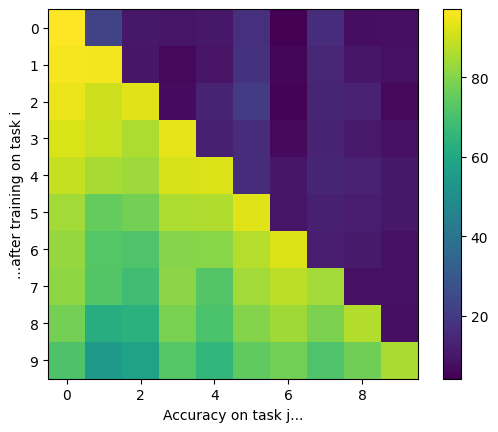

In [11]:
visualize_accs_matrix(test_accs_matrix, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)

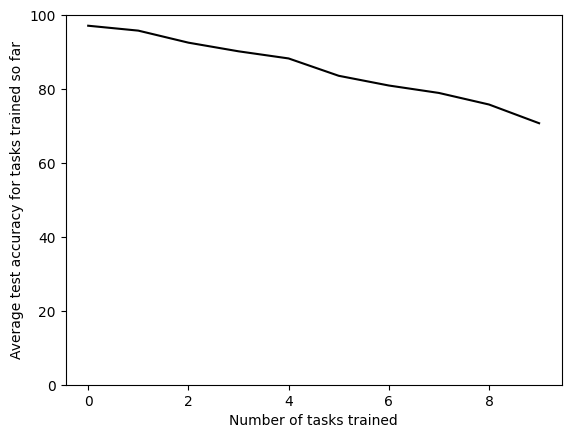

In [12]:
visualize_avg_acc_curve(test_accs_matrix, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)

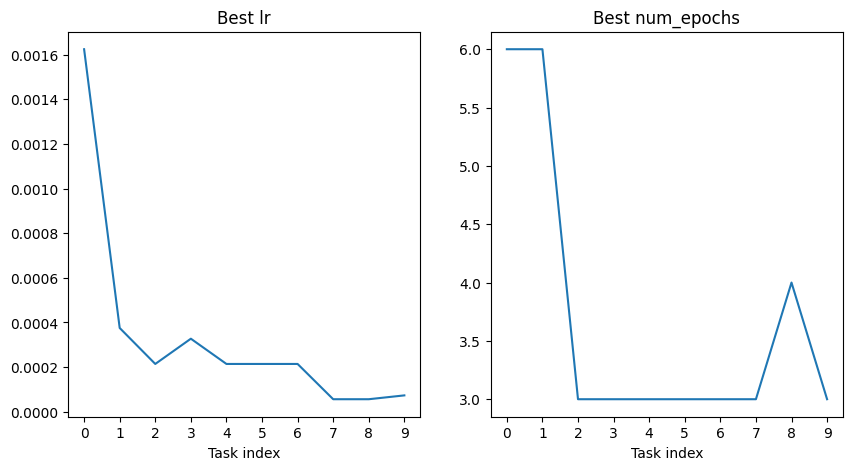

In [13]:
visualize_best_params(best_params_list, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)

# Validation benchmarks

## Reproducibility

In [14]:
permutation_random_seeds_list = [list(range(num_tasks*(i), num_tasks*(i+1))) for i in range(0,num_val_benchmarks+1)]

## Get p-MNIST loaders

In [15]:
test_loaders_list_list = []
for i in range(num_val_benchmarks+1) :
    permutation_random_seeds = permutation_random_seeds_list[i]
    test_loaders_list = []
    for random_seed in permutation_random_seeds :
        _, _, test_loader = get_task_loaders(data_path, batch_size, random_seed, train_percentage=train_percentage, difficulty="difficult", download=False)
        test_loaders_list += [test_loader]
    test_loaders_list_list += [test_loaders_list]

In [16]:
val_accs_matrix = np.zeros((num_val_benchmarks+2, num_tasks))

In [17]:
def train_with_best_params (best_params_list, test_loaders_list) :
    # Initialize model
    benchmark_model = ANN(num_inputs, num_hidden_root, num_outputs, random_seed).to(device)

    # Intialize mask
    if grow_from == "input" :
        overall_masks = [np.ones_like(benchmark_model.fc1.weight.data.cpu().numpy()),
                        np.ones_like(benchmark_model.fc2.weight.data.cpu().numpy())]
    else :
        overall_masks = [np.ones_like(benchmark_model.fc2.weight.data.cpu().numpy()),
                        np.ones_like(benchmark_model.fc3.weight.data.cpu().numpy())]

    for task_number in range(0,num_tasks) :

        # Verbose
        print("\n" + "-"*50)
        print(f"LEARNING TASK {task_number+1}")

        # Retrain and save a model with the best params
        is_first_task = True if task_number==0 else False
        params = overall_masks, is_first_task
        overall_masks = retrain_and_save_with_best_HPs(benchmark_model, params, best_params_list[task_number], test_loaders_list[task_number]) 
    
    return benchmark_model

In [18]:
for i in range(num_val_benchmarks+2) :
    benchmark_number = 0 if i <= 1 else i-1
    print("\n" + "="*50)
    print(f"BENCHMARK {benchmark_number}")
    # Train model with best params obtained through HPO on benchmark 0
    if i != 0 :
        test_loaders_list = test_loaders_list_list[benchmark_number]
        benchmark_model = train_with_best_params (best_params_list, test_loaders_list)
    else : 
        benchmark_model = copy.deepcopy(model)
    # Test on each task
    for j in range(num_tasks) :
        val_accs_matrix[i,j] = round(test(benchmark_model, test_loaders_list_list[benchmark_number][j], batch_size, device),2)


BENCHMARK 0



BENCHMARK 0

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 135
fc2 : in = 135, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 219
fc2 : in = 219, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 219
fc2 : in = 219, out = 101
fc3 : in = 101, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 219
fc2 : in = 219, out = 101
fc3 : in = 101, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 338
fc2 : in = 338, out = 101
fc3 : in = 101, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 338
fc2 : in = 338, out = 101
fc3 : in = 101, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 338
fc2 : in = 338, out = 101
fc3 : in = 101, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 338
fc2 : in = 338, out = 101
fc3 : in = 101, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 338
fc2 : in = 338, out = 101
fc3 : in = 101, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 338
fc2 : in = 338, out = 101
fc3 : in = 101, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 338
fc2 : in = 338, out = 101
fc3 : in = 101, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 338
fc2 : in = 338, out = 101
fc3 : in = 101, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


BENCHMARK 1

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


BENCHMARK 2

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 119
fc2 : in = 119, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 119
fc2 : in = 119, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 119
fc2 : in = 119, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 119
fc2 : in = 119, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 119
fc2 : in = 119, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 119
fc2 : in = 119, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 119
fc2 : in = 119, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 119
fc2 : in = 119, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 119
fc2 : in = 119, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 119
fc2 : in = 119, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 137
fc2 : in = 137, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 137
fc2 : in = 137, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 137
fc2 : in = 137, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


BENCHMARK 3

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


BENCHMARK 4

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


BENCHMARK 5

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


BENCHMARK 6

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 149
fc2 : in = 149, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 149
fc2 : in = 149, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 149
fc2 : in = 149, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 149
fc2 : in = 149, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 149
fc2 : in = 149, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


BENCHMARK 7

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 159
fc2 : in = 159, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 159
fc2 : in = 159, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 159
fc2 : in = 159, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 159
fc2 : in = 159, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 159
fc2 : in = 159, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


BENCHMARK 8

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


BENCHMARK 9

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.16s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


BENCHMARK 10

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 142
fc2 : in = 142, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


BENCHMARK 11

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 137
fc2 : in = 137, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 137
fc2 : in = 137, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 137
fc2 : in = 137, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 137
fc2 : in = 137, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 167
fc2 : in = 167, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


BENCHMARK 12

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


BENCHMARK 13

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 150
fc2 : in = 150, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 150
fc2 : in = 150, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 150
fc2 : in = 150, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 150
fc2 : in = 150, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 150
fc2 : in = 150, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 150
fc2 : in = 150, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 150
fc2 : in = 150, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 150
fc2 : in = 150, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 150
fc2 : in = 150, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 150
fc2 : in = 150, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 150
fc2 : in = 150, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


BENCHMARK 14

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 103
fc2 : in = 103, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 103
fc2 : in = 103, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 103
fc2 : in = 103, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 103
fc2 : in = 103, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 141
fc2 : in = 141, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


BENCHMARK 15

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.16s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.17s/it]


BENCHMARK 16

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 126
fc2 : in = 126, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


BENCHMARK 17

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


BENCHMARK 18

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.15s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.15s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.16s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.16s/it]


BENCHMARK 19

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.11s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.11s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.14s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 101
fc2 : in = 101, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.12s/it]

In and out sizes :
fc1 : in = 784, out = 101
fc2 : in = 101, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 101
fc2 : in = 101, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 101
fc2 : in = 101, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.13s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 101
fc2 : in = 101, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.13s/it]

In and out sizes :
fc1 : in = 784, out = 101
fc2 : in = 101, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.14s/it]

In and out sizes :
fc1 : in = 784, out = 101
fc2 : in = 101, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.13s/it]


BENCHMARK 20

--------------------------------------------------
LEARNING TASK 1


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.10s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.10s/it]


--------------------------------------------------
LEARNING TASK 2


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 17%|████████████████████████                                                                                                                        | 1/6 [00:01<00:05,  1.07s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 2/6 [00:02<00:04,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 3/6 [00:03<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 4/6 [00:04<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 5/6 [00:05<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.06s/it]


--------------------------------------------------
LEARNING TASK 3


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


--------------------------------------------------
LEARNING TASK 4


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


--------------------------------------------------
LEARNING TASK 5


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


--------------------------------------------------
LEARNING TASK 6


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


--------------------------------------------------
LEARNING TASK 7


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


--------------------------------------------------
LEARNING TASK 8


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]


--------------------------------------------------
LEARNING TASK 9


  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 25%|████████████████████████████████████                                                                                                            | 1/4 [00:01<00:03,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 2/4 [00:02<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 3/4 [00:03<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.06s/it]


--------------------------------------------------
LEARNING TASK 10


  0%|                                                                                                                                                        | 0/3 [00:00<?, ?it/s]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 33%|████████████████████████████████████████████████                                                                                                | 1/3 [00:01<00:02,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 2/3 [00:02<00:01,  1.06s/it]

In and out sizes :
fc1 : in = 784, out = 100
fc2 : in = 100, out = 100
fc3 : in = 100, out = 10


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.06s/it]

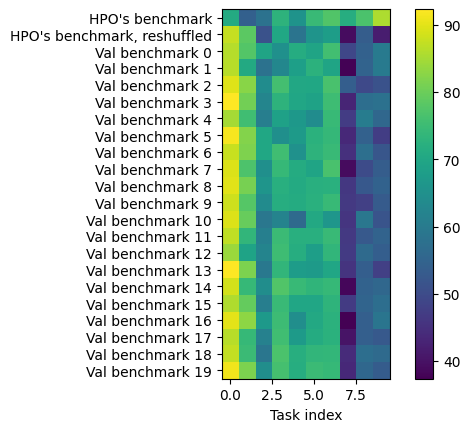

In [19]:
visualize_val_accs_matrix(val_accs_matrix, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)

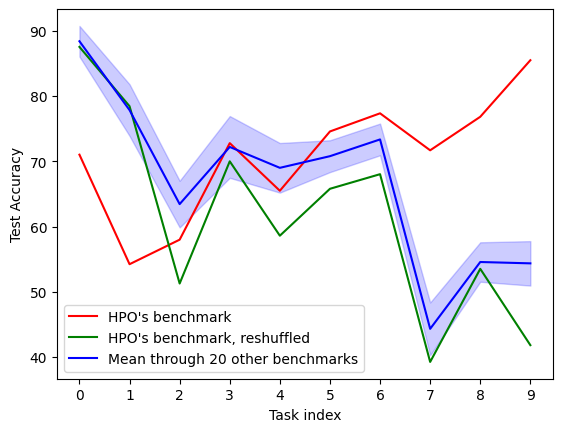

In [20]:
visualize_accuracy_through_benchmarks(val_accs_matrix, HPO_name, num_val_benchmarks, method_name, grow_from, benchmark_name, difficulty, savefig=True)

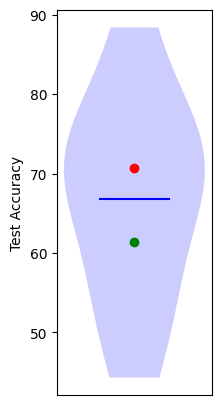

In [21]:
visualize_violin(val_accs_matrix, HPO_name, method_name, grow_from, benchmark_name, difficulty, savefig=True)